# Cut-it

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

Comenzamos importando librerías a usar:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree # fast K-neighbors queries
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel as pairwise_gaussian_similarity
# for display in cells
from IPython.display import clear_output
from sys import stdout 
from scipy.sparse.linalg import eigsh as SquareSymmetricEigenvalues
%matplotlib inline

Cargamos algunas imágenes de prueba, una imagen un poco más compleja de un ave, y una imagen un poco *toy* de unas pastillas.

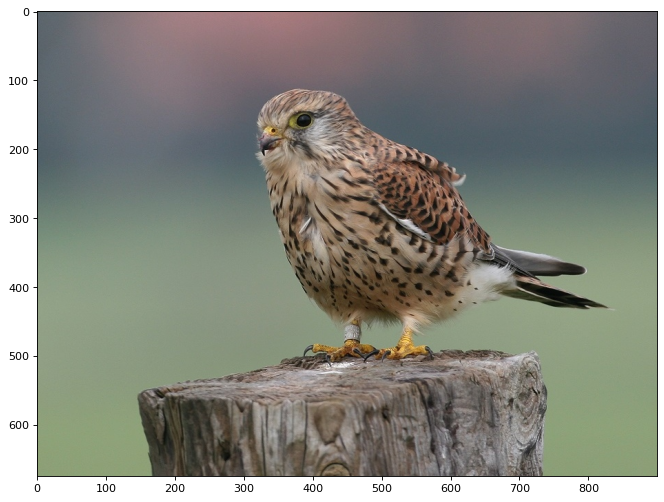

In [2]:
bird = cv2.cvtColor(cv2.imread('imgs/bird.jpg'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(bird)

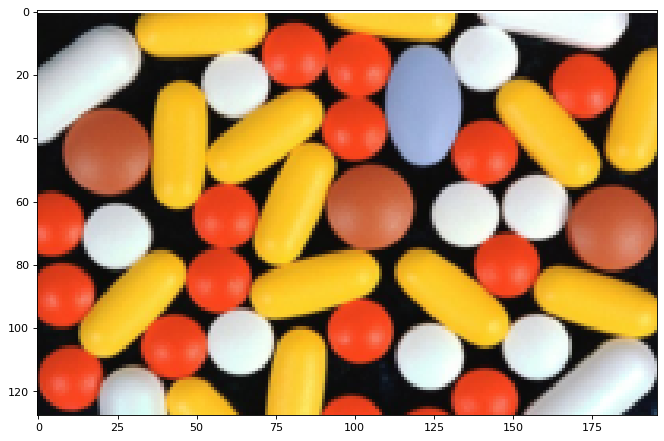

In [3]:
pills = cv2.cvtColor(cv2.imread('imgs/pills.png'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(pills)

Notesé que esperaríamos en el caso de las pastillas, poder segmentar las pastillas por color y separarlas, o asimismo cada uno su frontera. Este sería el objetivo final.

Para realizar la segmentación implementaremos los algoritmos de mean-shift y de spectral graph-based clustering.
Estos algoritmos más allá que algoritmos de segmentación en realidad son algoritmos de clustering, solamente que los aplicamos en nuestras imagenes para obtener regiones, y así definir separaciones en nuestra imagen.

Esto claramente viene a un precio un poco alto, y es que hay distintas maneras de manejar una imagen como puntos.
Se podrían considerar como puntos en $\mathbb{R}^3$ ó $\mathbb{R}^5$, considerando cada píxel como punto, sin embargo las imagenes modernas, son de tamaño significativamente grande, luego consideraremos estrategías y discutiremos esto más adelante. 

Para comenzar, realizamos la implementación del algoritmo de *mean-shift* nótese que este algoritmo es totalmente ágnostico de aplicación, no necesariamente se usa para segmentación de imagenes, aunque es un uso bueno del algoritmo.

El algoritmo recibe un conjunto de puntos y una ventana de radio `radius` que va agrupando los puntos según su convergencia.

In [4]:
def mean_shift(pts, radius , shift_stop_dist = 1e-3, mix_convergence=1e-3,  geometric_mean=True, max_iters = int(10e5), display_error=True):
    # make points positive 
    if geometric_mean:
        offset = pts.min(axis=0)
        pts = (pts - offset) + 1
    
    def mass_center(ipts, geometric=True):
        if geometric:
            return np.exp(np.mean(np.log(ipts), axis=0))
        else:
            return np.mean(ipts, axis=0)

    tree = BallTree(pts)
    prev_mean = None
    pts_mean = pts.copy()

    iters = 0
    donemask = np.zeros(len(pts), dtype=bool)

    while True:
        # Only update and calculate those who are NOT done.
        prev_mean = pts_mean.copy()
        idx = tree.query_radius(pts_mean[~donemask], r=radius)
        
        pts_mean[~donemask] = np.array([mass_center(pts[i], geometric=geometric_mean) for i in idx])

        # Calculate average shift
        if display_error:
            shifted = np.mean(np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1))
        

        donemask[~donemask] = np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1) < shift_stop_dist

        if display_error:
            clear_output()
            stdout.write(f"Average shift distance: {shifted}")
            stdout.flush()

        if np.all(donemask):
            break

        iters += 1
        if iters >= max_iters:
            break
        

    tagged = {}
    temp_tree = BallTree(pts_mean)
    centroids = []
    curr_class = 0
    for i in range(len(pts_mean)): # Linear in convergence of classes, still kind of slow just due to it being raw python
        if tagged.get(i) is not None:
            continue
        res = temp_tree.query_radius(pts_mean[i].reshape(1, -1), r=mix_convergence)[0]

        centroids.append(pts_mean[i])
        tagged[i] = curr_class
        # print(res)
        for k in res:
            tagged[k] = curr_class
        curr_class += 1

    if geometric_mean:
        return np.array(centroids) + offset - 1 , [tagged[i] for i in range(len(pts_mean))]
    else:
        return np.array(centroids), [tagged[i] for i in range(len(pts_mean))]


Para probar el algoritmo generemos unos puntos en el plano, para fácil visualización y que posean una relación no lineal. Para ver que tan bien se comporta *mean-shift* con estos puntos. Se supone que no detecta tan bien estas relaciones.

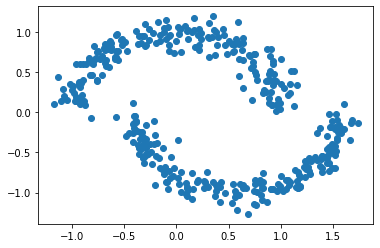

In [5]:
rng = np.random.default_rng(42)

N = 200
t = rng.random([N, 1]) * np.pi
t2 = rng.random([N, 1]) * np.pi + np.pi

pts1 = np.column_stack([np.cos(t), np.sin(t)])
pts2 = np.column_stack([np.cos(t2), np.sin(t2)])

pts2[:,0] += 0.6

# noisify.-
pts1 += rng.normal(scale=0.1,size=[N, 2])
pts2 += rng.normal(scale=0.1,size=[N, 2])


pts = np.row_stack([pts1, pts2])
plt.scatter(pts[:,0], pts[:,1])
plt.show()

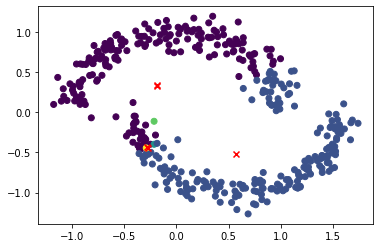

In [6]:
centroids, labels = mean_shift(pts, radius=1.2, geometric_mean=True, display_error =False)
plt.scatter(pts[:,0],pts[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red')

Podemos ver que nuestro algoritmo no es capaz de realizar una segmentación perfecta de los dos cluster o grupos de puntos esperados, los superiores y los inferiores. Sin embargo se apróxima de manera satisfactoria a la solución.

Opcionalmente, por términos de precisión númerica y de eficiencia, se ha añadido parametros adicionales, de *shift_stop_dist* este es un número de precisión númerica que representa cuando se considera que el shift ha convergido.

Por otro lado existe el *mix_convergence* que determina en que rango se van a mezclar las convergencias en una sola moda/centroide. Puesto al final del mean-shift se deben agrupar los centroides convergidos muy cercanamente en uno solo.

Modificando estos dos parámetros se pueden obtener resultados muy buenos y en muy poco tiempo!

Cabe destacar que el resultado es muy dependiente del párametro *r* del radio, puesto es capaz de asociar a todo en una misma clase o realizar una mejor segmentación como mostrada en la imagen.

Si ajustamos distintos párametros de *r* podemos ver que se van ajustando que tan finos y granulares son los clusters generados.

## Segmentación de Imagenes - Helper

Ahora hagamos uso de este algoritmo de clustering, pero con una aplicación concreta, segmentación de imágenes, para esto haremos uso de varias funciones helper que definiremos a continuación:

Primero definiremos funciones para cambiar de espacios de colores, usualmente con las imágenes se trabaja en formato *RGB* pero muchas veces es mejor trabajar con distintos formatos de color, tales como *LAB* o *LUV*.
Dado en estos espacios de colores un cambio *perceptual* en la imagen de color, se ve reflejado de manera lineal/proporcional en el espacio de color. Esto no necesariamente ocurre en el espacio de *RGB*.

Esto lo vemos a continuación:

In [7]:
## Wrapper Helper labspace functions
def img2space(img, cv2space):
    original_shape = img.shape
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = img.astype(np.float32)
        return cv2.cvtColor((img.reshape(-1,1,3) * 255).astype(np.uint8), cv2space).reshape(original_shape) / 255
    return cv2.cvtColor(img.reshape(-1,1,3), cv2space).reshape(original_shape)
  
def lab2rgb(img):
    return img2space(img, cv2.COLOR_LAB2RGB)

def rgb2lab(img):
    return img2space(img, cv2.COLOR_RGB2LAB)

def rgb2luv(img):
    return img2space(img, cv2.COLOR_RGB2LUV)

def luv2rgb(img):
    return img2space(img, cv2.COLOR_LUV2RGB)

Ahora definiremos varias funciones helper para trabajar con imágenes. Recordemos que existen dos maneras básicas de segmentar e interpretar imágenes como puntos en un espacio $\mathbb{R}^n$.

- 1. Como puntos en $\mathbb{R}^3$ (Espacio de color). En este caso usualmente se considera solamente el espacio de color. Es decir, consideramos como es la distribución de color en nuestra imagen y la buscamos agrupar en regiones según cada pixel. De esta manera es equivalente a hacer una quantización de color, donde cada color quantizado nos define una región o separación. 

- 2. Como puntos en $\mathbb{R}^5$. En este caso se considera no solo el espacio de color, sino que se le adiciona la información posicional de la imagen a los puntos. 

En general cada uno tienes sus beneficios, en el primer caso claramente se obvia la información posicional que puede ser crucial en la segmentación de una imagen. En el caso de las pastillas por ejemplos, se asociaria todas las pastillas de color rojo, y se esperaría segmentar cada pastilla individualmente, por lo cual no nos daría los mejores resultados.
Sin embargo, se trabaja con una menor dimensionalidad, reduciendo costos de computos y complejidad, evitando lo que se llama la maldición de la dimensionalidad.

En este notebook haremos pruebas con ambos de estos, y por esto se diseñan los métodos helper adicionales:


In [8]:
def position_extend_mat(mat, weight = 1):
    n,m, _ = np.shape(mat)
    X,Y = np.meshgrid(np.linspace(0, 1, m), np.linspace(0,1, n))
    helpmat = np.zeros((mat.shape[0], mat.shape[1], mat.shape[2] + 2))
    helpmat[:,:,:mat.shape[2]] = mat
    helpmat[:,:,-2] = X * weight
    helpmat[:,:,-1] = Y * weight
    return helpmat
    
def img2R5(input_img, normalize=True, dist_scale=1, color_scale=1, space = 'rgb'):

  if input_img.max() > 1 and normalize:
    help_img = input_img.astype('float32') / 255
  else:
    help_img = input_img.copy()

  if space == 'rgb':
    pass
  elif space == 'luv':
    help_img = rgb2luv(help_img)
  elif space == 'lab':
    help_img = rgb2lab(help_img)
  else:
    raise ValueError(f'Invalid Space flag {space}')

  help_img = help_img*color_scale # either expand or make colors closers.
  help_img = position_extend_mat(help_img, dist_scale)
  return help_img.reshape(-1,5)

def img2R3(input_img, normalize=True, only_color=True, dist_scale=1, color_scale=1, space='rgb'):

  if normalize and input_img.max() > 1:
    img = input_img.astype('float32') / 255
  else:
    img = input_img.copy()

  if space == 'rgb':
    pass
  elif space == 'luv':
    img = rgb2luv(img)
  elif space == 'lab':
    img = rgb2lab(img)
  else:
    raise ValueError(f'Invalid Space flag {space}')
  
  img = img * color_scale
  if only_color:
    return img.reshape(-1,3)
  else:
    img = img.mean(axis=2)
    img = img.reshape(img.shape[0],img.shape[1],1)
    return position_extend_mat(img, dist_scale).reshape(-1,3)
    

Por último es necesario definir como visualizar nuestros resultados. El objetivo final es realizar una *segmentación* es decir segmentar la imagenes en distintas regiones (no necesariamente conexas, aunque idealmente conexas). En la que cada pixel se asigna a una región.

De esta manera, se construyen tres, una directa, que es sencillamente la separación de cada región en distintas imágenes, una que es quantizar la imagen según la región de los centroides, y otra de obtener bordes a cada región y sobreponerlas sobre la original.

Esto se hace a continuación:

In [9]:
def get_region_splits(img, labels):
    matlabels = np.array(labels).reshape(img.shape[0],img.shape[1])
    regionimgs = []
    for region in range(matlabels.max() + 1):
        regionmask = matlabels == region
        regionimg = np.zeros(np.shape(img), dtype=img.dtype)
        regionimg[regionmask] = img[regionmask]

        regionimgs.append(regionimg)

    return regionimgs

def get_region_quantized(img, labels, centroids, scale_centroids = 255):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    for label in range(matlabels.max() + 1):
        display[matlabels == label] = centroids[label] * scale_centroids
    return display

def get_image_splitted(img, labels, border_color = [255,255,255], thickness=2):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    dilate_kernel = np.ones((thickness, thickness), 'uint8')
    for label in range(matlabels.max() + 1):
        regionmask = matlabels == label
        regionedges = cv2.Canny(regionmask.astype('uint8')*255, 80, 200)
        dilated_edges_img = cv2.dilate(regionedges,dilate_kernel, iterations=1)
        
        display[dilated_edges_img == 255] = border_color

    return display

Ahora tenemos todas las herramientas para probar los algoritmos de manera sencilla y directa, comenzaremos revisando el mean-shift y probaremos con distintos variaciones y ver como se comportan.

## Pills

Consideremos la imagen toy de las pastillas previamente, se esperaría segmentación muy buena, en especial en el espacio de color.

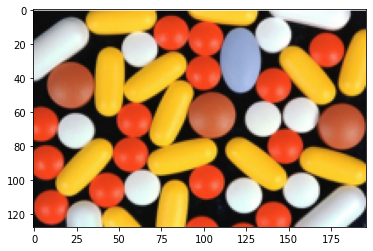

In [10]:
plt.imshow(pills)

Consideramos la imagen como puntos en el espacio de color de $\mathbb{R}^3$:

In [11]:
pills3dpts = img2R3(pills, only_color=True)

Y aplicamos *mean shift* en este caso sin usar la media geométrica dado se obtienen mejores resultados.

In [12]:
centroids, labels = mean_shift(pills3dpts, radius=0.3, shift_stop_dist = 0.01, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0052673122845590115

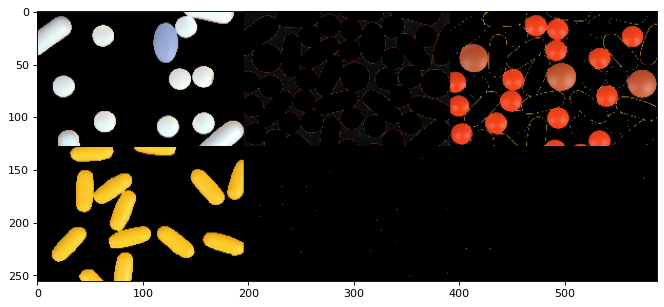

In [13]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(np.row_stack([
  np.column_stack(regionimgs[:3]),
  np.column_stack(regionimgs[3:]),
]))

Podemos ver obtenemos una separación bastante buena para comenzar. En la cual se separan los colores más blancos, los rojos, los amarillos y los negros.
Cabe destacar dos detalles y es que en esta visualización no se visualiza correctamente las regiones negras, sin embargo, hay oportunidades de mejoras.

Podemos ver que hay una pastilla que es ligeramente azul, no es blanca y esperaríamos que se segmentara en una región distinta. Esperariamos que esta region que detecto los bordes, no fueran detectadas. Esto se debe por cambios de iluminación en la imagen, en los que los centros de la pastillas tienden a ser distintos (más brillantes) que los bordes de estos.

Lo visualizamos como una cuantización del color y con los bordes:

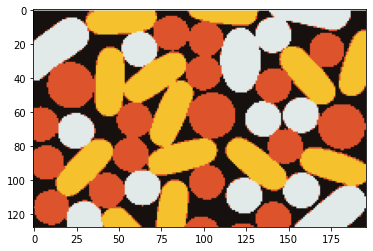

In [14]:
%matplotlib inline
quantized = get_region_quantized(pills, labels, centroids)
plt.imshow(quantized)

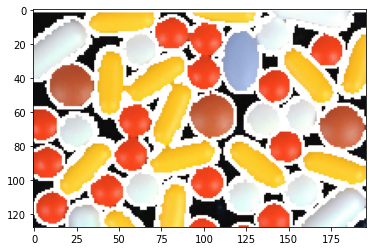

In [15]:
splitted = get_image_splitted(pills, labels)
plt.imshow(splitted)

Podemos ver obtenemos una segmentación satisfactoria, pero podemos hacerlo mejor?

### Using LUV-space

Ahora usaremos el espacio CIELUV, este espacio busca crear ser uniforme con respecto a colores percibidos, y debería mejorar nuestros resultados.

In [16]:
pills3dptsluv = img2R3(pills, space='luv')

In [17]:
centroids, labels = mean_shift(pills3dptsluv, radius=0.12, shift_stop_dist = 1e-3, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.00016866506184193725

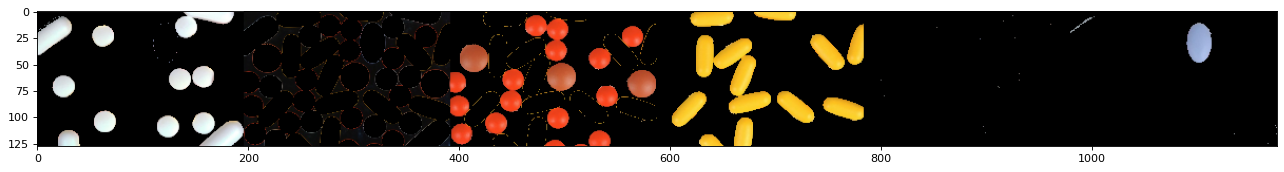

In [18]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
plt.figure(num=None, figsize=(20, 10), dpi=80)
plt.imshow(np.column_stack(regionimgs[:20]))

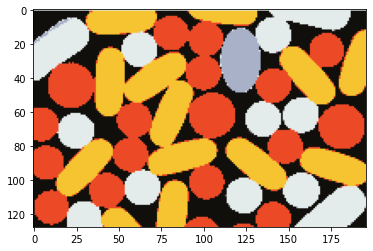

In [19]:
quantized = get_region_quantized(pills, labels, luv2rgb(centroids))
plt.imshow(quantized)

Podemos ver que se obtienen una vez más buenos resultados, sin embargo sigue detectando bordes innecesarios aunque menos, y es capaz de detectar la diferencia entre la pastilla azul y las blancas.

Cabe destacar que para obtener estos resultados es necesario modificar mucho los párametros de *mean-shift*¨en especial el radio. Haciendo obtener un buen resultado a veces un proceso tedioso dado que puede ser demorado y en general computacionalmente costoso.

## Pills - Position Included

Ahora tratemos de mejorar nuestra segmentación incluyendo la información posicional de la imagen. 
De esta manera nuestros puntos ahora tienen 2 dimensiones adicionales $x$ y $y$ que se normalizan y se obtienen puntos en el hipercubo $[0,1]$^5.

Sin embargo, como detalle adicional, podemos determinar unos pesos para estas dimensiones (de cierta manera, denormalizando los datos) según pesos deseados, para obtener mejores resultados.

Para esta imagen de las pastillas, se realiza una segmentación con un weighting de distancias de 2.85, es decir las dimensiones de $x$ y $y$ van a jugar un papel más importante en la segmentación, y se reduce la distancia de la escala de color, para que sea menos importante.

Esto se debe a que nuestros pastillas son de colores muy similares, y queremos obtener pastillas de manera individual por lo que necesitamos que se diferencien los datos de manera correcta.

In [20]:
pills5d = img2R5(pills, dist_scale=2.85, color_scale=0.5, space='luv')

In [21]:
centroids, labels = mean_shift(pills5d, radius=0.25, shift_stop_dist = 1e-4, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0

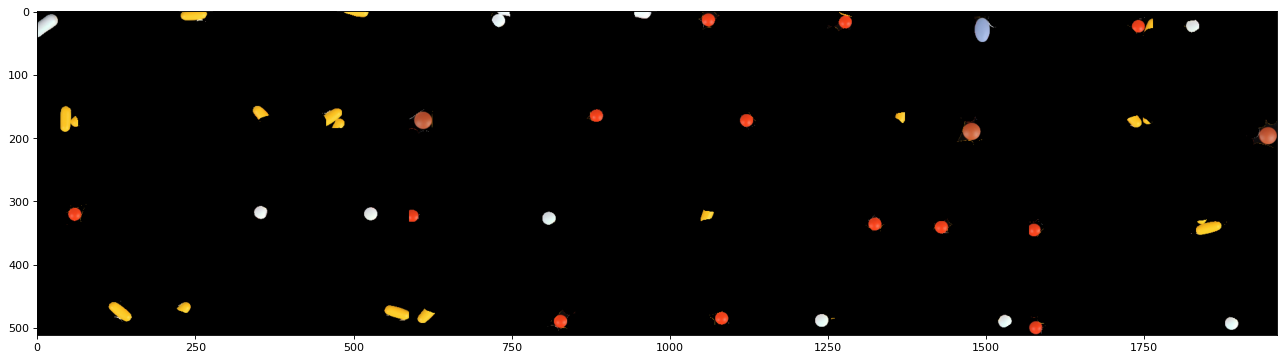

In [22]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
nonblackregions = [reg for reg in regionimgs if reg.mean() > 1]
plt.figure(num=None, figsize=(20, 20), dpi=80)
displayblock = np.row_stack([
    np.column_stack(nonblackregions[0:10]),
    np.column_stack(nonblackregions[10:20]),
    np.column_stack(nonblackregions[20:30]),
    np.column_stack(nonblackregions[30:40]),
    ]
)

plt.imshow(displayblock)

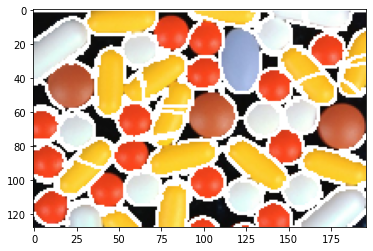

In [23]:
splitted = get_image_splitted(pills, labels, thickness=2)
plt.imshow(splitted)

Podemos ver que con los parámetros adecuados, y el radio adecuado, se obtienen resultados increiblemente buenos!

Podemos ver que fue capaz de segmentar la mayoria de las pastillas individualmente, aunque algunas como ls marrones se mezclan con el fondo negro (dado su distancia cercana en el espacio de color). Además existen imperfecciones perfectamente entendibles entre pastillas adyacentes de un mismo color. Visualmente para el ojo humano es fácil determinar esta diferencia, pero para el algoritmo son del mismo color y son muy cercanas en el espacio $x$ $y$ por lo cual reciben una misma agrupación.

Ahora procedemos a probar el algoritmo con una imagen más compleja, y podemos ver los distintos problemas que acarrea.

## Bird

Procedemos a leer nuestra imagen de un ave en un tronco, dado es una imagen un poco grande y hacer este tipo de segmentación es computacionalmente costoso, reducimos el tamaño de la imagen significativamente para realizar la segmentación.

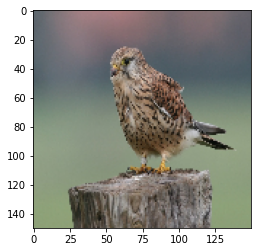

In [24]:
%matplotlib inline
smallbird = cv2.resize(bird, dsize=(150,150))

plt.imshow(smallbird)

La pasamos al espacio de color $LUV$ como puntos en $\mathbb{R}^3$

In [25]:
bird3dpts = img2R3(smallbird, space='luv')

In [26]:
centroids, labels = mean_shift(bird3dpts, radius=0.06, shift_stop_dist=1e-4, mix_convergence=0.01, geometric_mean=False)

Average shift distance: 6.727242211033063e-05

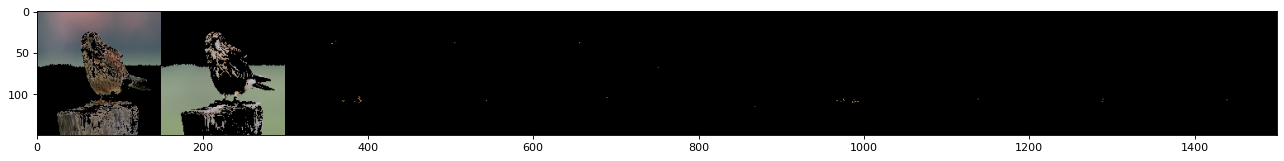

In [27]:
%matplotlib inline
imgregions = get_region_splits(smallbird, labels)

plt.figure(num=None, figsize=(20, 20), dpi=80)

displayblock = np.row_stack([
    np.column_stack(imgregions[0:10]),
    # np.column_stack(imgregions[10:20]),
    # np.column_stack(imgregions[20:30]),
    ]
)

plt.imshow(displayblock)

Podemos ver que no obtenemos una partición muy buena de la imagen, dado la gran cantidad de información y mucho detalle especialmente en el área del pájaro.

Para esto buscaremos simplificar la imagen con el concepto de superpixeles:

### SuperPixel Tuning

Buscaremos reducir la complejidad de la imagen, reduciendo a información especifica, simplificando así el clustering.

Aplicaremos KMeans y usaremos los $k$ centroides como superpíxeles, que representaran la imagen pero con mucha menos información, así podemos reducir una imagen preservando su calidad y funciona muy bien para la tarea de segmentación de regiones.

Para inicializar el kmeans es importante sin embargo, inicializarlo uniformemente, eso lo realizamos a continuación:

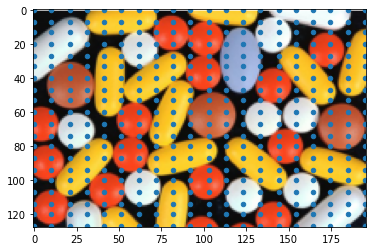

In [28]:
def uniform_initialize(img, m_samples = 100, n_samples = 100, normalize=True, display=True, display_size=0.5):
  n,m,_ = np.shape(img)
  # take uniform startup

  # there will be a total of m_samples * n_samples superpixels

  xpixels =  np.round(np.linspace(0,1,m_samples) * (m - 1)).astype('int')
  ypixels =  np.round(np.linspace(0,1,n_samples) * (n - 1)).astype('int')

  pts = np.transpose([np.tile(xpixels, len(ypixels)), np.repeat(ypixels, len(xpixels))]) # performs a cartesian product
  
  if display:
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter(pts[:,0],pts[:,1], s=display_size)
    plt.show()

  
  if normalize:
    return np.column_stack(
      [img[pts[:,1], pts[:,0]] / 255, 
                  pts[:,1] / (n - 1), pts[:,0] / (m - 1)])
  
  return np.column_stack([img[pts[:,1], pts[:,0]], pts])

m_samples, n_samples = 20, 20
startpoints = uniform_initialize(pills, m_samples, n_samples, display_size=20)

Podemos ver como se samplean uniformemente puntos de la imagen, puntos en $R^5$, representando el espacio de color en LUV y la posición $x$ $y$.

Así generamos una función para superpixelar la imagen, usando kmeans:

In [29]:
def superpixelize(img, m_samples, n_samples, space='rgb', max_iter = 300):
  startpoints = uniform_initialize(img, m_samples, n_samples, display=False)
  clusterer = KMeans(n_clusters=m_samples*n_samples, init=startpoints, random_state=42, n_init=1, verbose=0, max_iter=max_iter)
  clusterer.fit(img2R5(img, space=space))
  return clusterer.cluster_centers_, clusterer.labels_

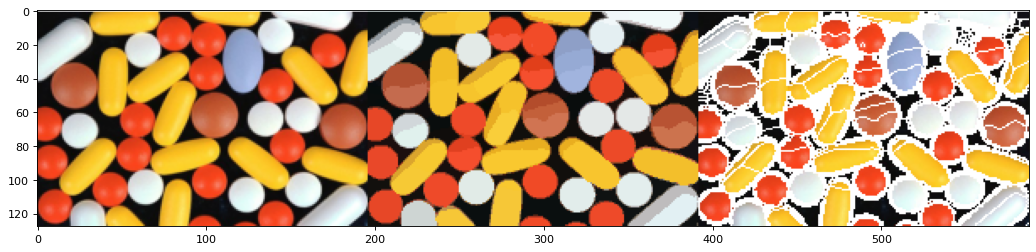

In [61]:
superpillspixels, superpills_labeling = superpixelize(pills, 20, 20, space='luv')

quantized = get_region_quantized(pills, superpills_labeling, luv2rgb(superpillspixels[:,:3]))
splitted = get_image_splitted(pills, superpills_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([pills, quantized, splitted]))

Al probar con las pastillas, podemos ver que nuestro algoritmo claramente no es perfecto, pero conserva la percepción general de la imagen, de manera satisfactoria.

El principal problema es que aplicar KMeans los superpíxeles van a tender a agruparse a regiones de mayor información, y así no van a ser tan uniformes como se esperarian.

Retomemos nuestra imagen de pajaro original, aplicando superpíxeles:

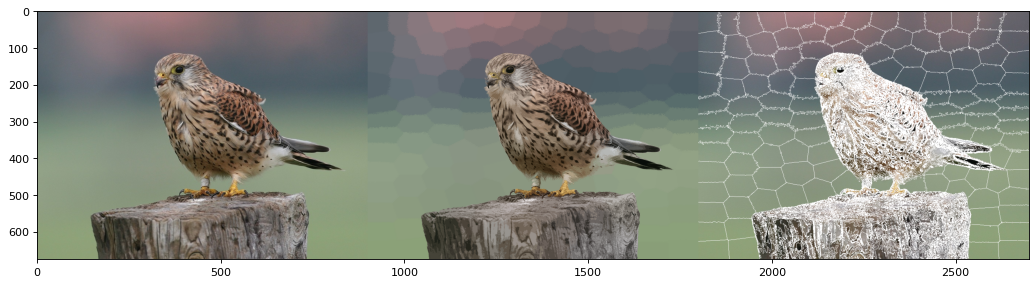

In [31]:
superbirdpixels, superbirdpixels_labeling = superpixelize(bird, 20, 20, space='luv')

quantized = get_region_quantized(bird, superbirdpixels_labeling, luv2rgb(superbirdpixels[:,:3]))
splitted = get_image_splitted(bird, superbirdpixels_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([bird, quantized, splitted]))

Podemos ver que posee los mismos problemas previamente vistos, en los cuales los superpixeles se agrupan en regiones de mayor información, y a veces, dado queremos generalizar las regiones, esto no es de mucha conveniencia.

Ahora aplicamos nuestro algoritmo de mean-shift.

In [46]:
centroids, labels = mean_shift(superbirdpixels, radius=0.25, shift_stop_dist=1e-4, mix_convergence=0.01, geometric_mean=False)
labels = np.array(labels)

Average shift distance: 0.0

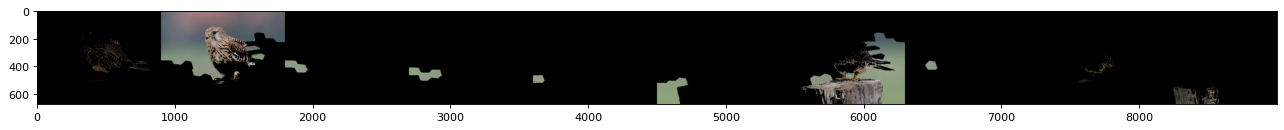

In [47]:
%matplotlib inline
imgregions = get_region_splits(bird, labels[superbirdpixels_labeling])

plt.figure(num=None, figsize=(20, 20), dpi=80)

displayblock = np.row_stack([
    np.column_stack(imgregions[0:10]),
    # np.column_stack(imgregions[10:20]),
    # np.column_stack(imgregions[20:30]),
    ]
)

plt.imshow(displayblock)

Podemos ver que la segmentación mejora un poco en comparación a la anterior, pero deja mucho que desear.

## Spectral Clustering

Para tratar de mejorar nuestra segmentación, ahora usaremos la técnica de spectral clustering.

Esta se encuentra más detalladamente en el paper: von Luxburg, U. (2007). A Tutorial on Spectral Clustering. doi:10.48550/ARXIV.0711.0189
En el cual se basa para implementar el algoritmo de *Normalized spectral clustering according to Ng, Jordan, and Weiss (2002)*

Se omitiran los detalles de implementación, y se hará un uso general del algoritmo. Solamente cabe destacar que es un algoritmo de clustering que funciona basado en hallar regiones subconexas de grafos, basado en pesos o similitudes entre cada par de puntos. Por esto el algoritmo posee una complejidad *de almenos* cuadrática, por lo cual es imprescindible o reducir de tamaño la imagen, o reducirla a superpíxeles.

La implementación del algoritmo se encuentra a continuación, en los cuales recibe $k$ regiones deseadas, y un sigma que es usado para construir la distancia gaussiana entre los puntos, y así entre las regiones.

In [48]:
def NormalizedSpectralClustering(pts, sigma, k = 4):
  weights = pairwise_gaussian_similarity(pts, gamma=1/(2*sigma*sigma))
  D = np.diag(weights.sum(axis=0))

  Dm12 = np.sqrt(np.linalg.inv(D))
  Lsym = np.eye(np.shape(D)[0]) - Dm12 @ weights @ Dm12

  eigenvalues, eigenvectors = np.linalg.eig(Lsym)

  np.allclose(np.imag(eigenvalues), np.zeros(eigenvalues.shape)), 'Complex eigenvalues, numerical error'
  np.allclose(np.imag(eigenvectors), np.zeros(eigenvectors.shape)), 'Complex eigenvalues, numerical error'

  eigenvalues = np.real(eigenvalues)
  eigenvectors = np.real(eigenvectors)
  
  sortedindexes = eigenvalues.argsort()

  T = eigenvectors[:,sortedindexes[:k]]
  T = T/np.linalg.norm(T, axis=1, keepdims=True)

  clusterer2 = KMeans(n_clusters = k)
  clusterer2.fit(T) 

  return clusterer2.labels_

Primero hagamos una prueba con nuestra imagen "toy", la cual fue superpixelada previamente:

In [73]:
### Parameters
k = 50
sigma = np.mean(np.var(superpillspixels,axis=0))

superlabels = NormalizedSpectralClustering(superpillspixels, sigma, k)
img_labels = superlabels[superpills_labeling]

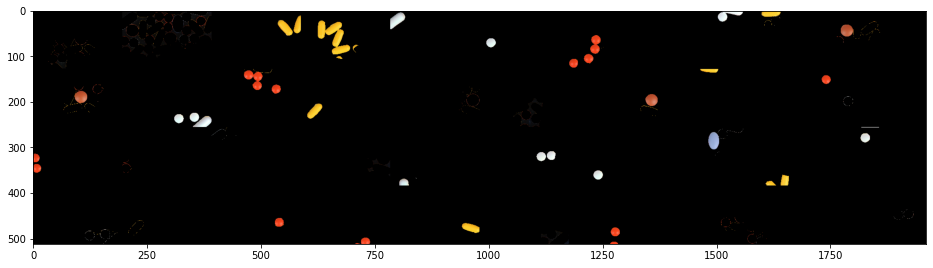

In [74]:
regionimgs = get_region_splits(pills, img_labels)

plt.figure(figsize=(16,12))
plt.imshow(np.row_stack([
  np.column_stack(regionimgs[:10]),
  np.column_stack(regionimgs[10:20]),
  np.column_stack(regionimgs[20:30]),
  np.column_stack(regionimgs[30:40])
]))

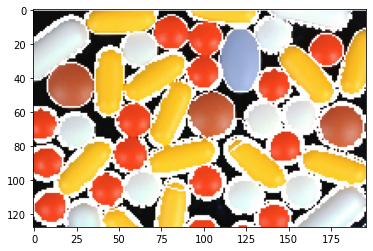

In [75]:
plt.imshow(get_image_splitted(pills, img_labels, thickness=1))

Podemos ver una vez más, que la segmentación no es perfecta, sin embargo, es significativamente superior a la realizada con mean-shift. Al considerar que realiza separaciones individuales por pastilla de manera satisfactoria, aunque claramente con el mismo problema de que las pastillas adyanentes del mismo color, se agrupan en una misma región.

Adicionalmente consideremos los datos vistos inicialmente que mean-shift no fue capaz de agrupar correctamente, dada su relación no lineal:

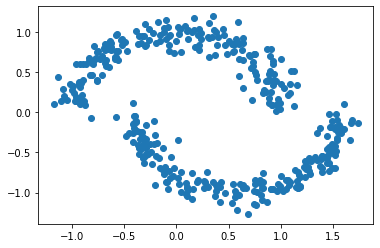

In [89]:
plt.scatter(pts[:,0], pts[:,1])
plt.show()

Si le aplicamos nuestro nuevo algoritmo de Spectral Clustering:

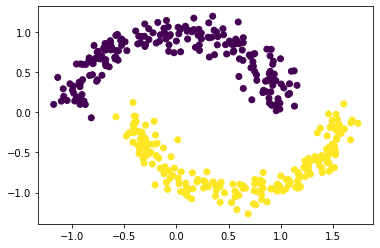

In [91]:
labels = NormalizedSpectralClustering(pts, sigma=0.1, k=2)
plt.scatter(pts[:,0],pts[:,1], c=labels)

Podemos ver lo potente que es este algoritmo de spectral clustering, obteniendo un split perfecto en este conjunto de datos, como sería de esperar.

Ahora veamos como funciona con nuestra imagen previa del ave.

In [76]:
k = 3
sigma = 10
superlabels = NormalizedSpectralClustering(superbirdpixels, sigma, k)
img_labels = superlabels[superbirdpixels_labeling]

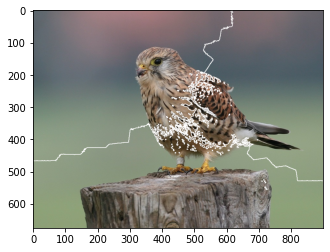

In [77]:
plt.imshow(get_image_splitted(bird, img_labels))

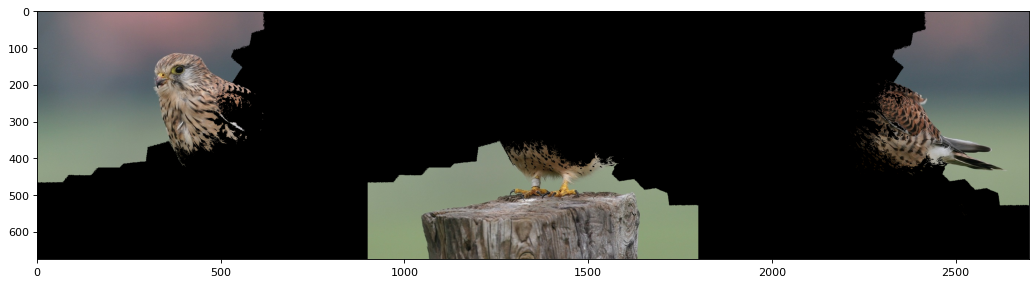

In [78]:
regionimgs = get_region_splits(bird, img_labels)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack(regionimgs))

Podemos ver que funciona relativamente, pero aún deja mucho que desear. El $k = 3$ proviene de que *idealmente* es esperaríanla region de fondo, el tronco y el ave. (O algo de ese estilo)

Para tratar de mejorar los resultados, se aplica un blur a la imagen para reducir detalles, y simplificar el proceso de regiones:

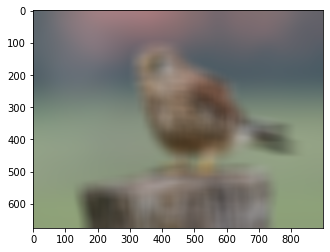

In [79]:
blurbird = cv2.blur(bird,(49,49),0)
plt.imshow(blurbird)

Aplicamos superpixeles a nuestra imagen difuminada

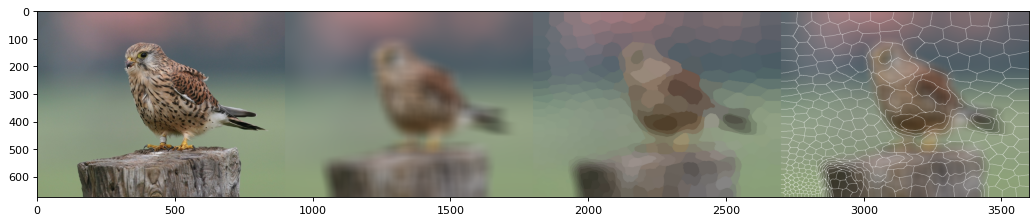

In [80]:
superpixels, superpixel_labeling = superpixelize(blurbird, 20, 20, space='luv')


quantized = get_region_quantized(blurbird, superpixel_labeling, luv2rgb(superpixels[:,:3]))
splitted = get_image_splitted(blurbird, superpixel_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([bird, blurbird, quantized, splitted]))

Podemos ver que los superpixeles ahora si aparentan ser más pequeños pixeles esparcidos, y así se podría esperar un mejor resultado.

Probamos para distintos valores de $k$

In [84]:
# k = 6
sigma = 5
superlabels_list = [NormalizedSpectralClustering(superpixels, sigma, k) for k in range(2,8)]
img_labels_list = [superlabels[superpixel_labeling] for superlabels in superlabels_list]

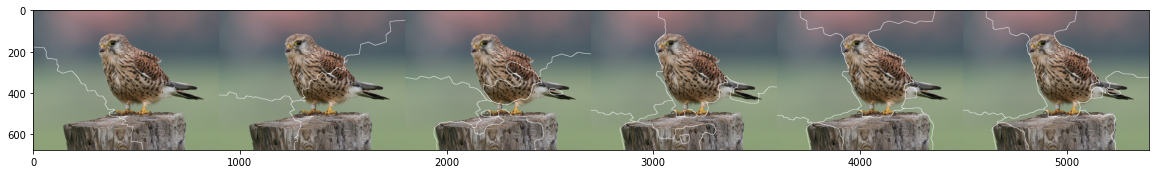

In [87]:
images = [get_image_splitted(bird, img_labels) for img_labels in img_labels_list ]


plt.figure(figsize=(20,12))
plt.imshow(np.column_stack(images))

Podemos ver que la separación claramente no es perfecta, pero mejora significativamente, y a medida que se aumentan el $k$, las regiones se van adaptando tanto al pajaro como al tronco.

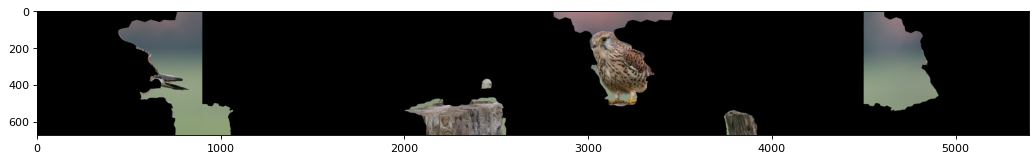

In [88]:
regionimgs = get_region_splits(bird, img_labels)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack(regionimgs))

Obteniendo así una segmentación decente, incluso para una imagen tan compleja como la vista.

## Conclusiones